# Lab 3: DenseNet Classification + Siamese Networks

**Tasks:**

1. Build DenseNet CNN for Fashion-MNIST classification (>90% accuracy)
2. Implement Siamese network for similar image search
3. Visualize embeddings with t-SNE


## Setup


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from tqdm.auto import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Using device: cpu


## Part 1: Data Preparation


In [2]:
transform_train = transforms.Compose(
    [
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

transform_test = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

train_dataset = torchvision.datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform_train
)
test_dataset = torchvision.datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform_test
)

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size]
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0)

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

print(
    f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}"
)

Train: 54000, Val: 6000, Test: 10000


## Part 2: DenseNet Architecture


In [3]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate, dropout=0.2):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(
            4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.dropout(out)
        return torch.cat([x, out], 1)


class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers, dropout=0.2):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                DenseLayer(in_channels + i * growth_rate, growth_rate, dropout)
                for i in range(num_layers)
            ]
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.pool = nn.AvgPool2d(2, stride=2)

    def forward(self, x):
        return self.pool(self.conv(F.relu(self.bn(x))))


class DenseNet(nn.Module):
    def __init__(
        self,
        growth_rate=12,
        block_config=(6, 12, 8),
        num_classes=10,
        dropout=0.2,
        compression=0.5,
    ):
        super().__init__()

        self.features = nn.Sequential()
        num_channels = 2 * growth_rate

        self.features.add_module(
            "conv0", nn.Conv2d(1, num_channels, kernel_size=3, padding=1, bias=False)
        )
        self.features.add_module("bn0", nn.BatchNorm2d(num_channels))
        self.features.add_module("relu0", nn.ReLU(inplace=True))

        for i, num_layers in enumerate(block_config):
            block = DenseBlock(num_channels, growth_rate, num_layers, dropout)
            self.features.add_module(f"denseblock{i + 1}", block)
            num_channels += num_layers * growth_rate

            if i != len(block_config) - 1:
                trans = TransitionLayer(num_channels, int(num_channels * compression))
                self.features.add_module(f"transition{i + 1}", trans)
                num_channels = int(num_channels * compression)

        self.features.add_module("bn_final", nn.BatchNorm2d(num_channels))
        self.features.add_module("relu_final", nn.ReLU(inplace=True))
        self.features.add_module("avgpool", nn.AdaptiveAvgPool2d((1, 1)))

        self.classifier = nn.Linear(num_channels, num_classes)
        self.num_features = num_channels

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = features.view(features.size(0), -1)
        out = self.classifier(out)
        return out

    def get_features(self, x):
        features = self.features(x)
        return features.view(features.size(0), -1)


model = DenseNet().to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 303,274


## Part 3: Training DenseNet


In [4]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return total_loss / total, 100.0 * correct / total


def validate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return total_loss / total, 100.0 * correct / total

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=3
)

num_epochs = 15
best_val_acc = 0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device
    )
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(
        f"Epoch {epoch + 1}/{num_epochs} - "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%"
    )

    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_densenet.pth")
        print(f"  → Saved best model (Val Acc: {val_acc:.2f}%)")

print(f"\nBest validation accuracy: {best_val_acc:.2f}%")

Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1/15 - Train Loss: 1.4242, Train Acc: 57.10% - Val Loss: 0.9107, Val Acc: 68.82%
  → Saved best model (Val Acc: 68.82%)
  → Saved best model (Val Acc: 68.82%)


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/15 - Train Loss: 0.7366, Train Acc: 75.68% - Val Loss: 0.6909, Val Acc: 74.35%
  → Saved best model (Val Acc: 74.35%)


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/15 - Train Loss: 0.5836, Train Acc: 79.20% - Val Loss: 0.6681, Val Acc: 74.72%
  → Saved best model (Val Acc: 74.72%)


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/15 - Train Loss: 0.5099, Train Acc: 81.58% - Val Loss: 0.5063, Val Acc: 81.55%
  → Saved best model (Val Acc: 81.55%)


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/15 - Train Loss: 0.4700, Train Acc: 82.87% - Val Loss: 0.5096, Val Acc: 81.28%


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 6/15 - Train Loss: 0.4409, Train Acc: 83.84% - Val Loss: 0.4605, Val Acc: 83.93%
  → Saved best model (Val Acc: 83.93%)


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7/15 - Train Loss: 0.4182, Train Acc: 84.79% - Val Loss: 0.4527, Val Acc: 83.37%


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8/15 - Train Loss: 0.3981, Train Acc: 85.64% - Val Loss: 0.4400, Val Acc: 83.68%


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9/15 - Train Loss: 0.3831, Train Acc: 85.95% - Val Loss: 0.4159, Val Acc: 84.95%
  → Saved best model (Val Acc: 84.95%)


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10/15 - Train Loss: 0.3718, Train Acc: 86.35% - Val Loss: 0.4361, Val Acc: 83.95%


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 11/15 - Train Loss: 0.3611, Train Acc: 86.88% - Val Loss: 0.4026, Val Acc: 85.67%
  → Saved best model (Val Acc: 85.67%)


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 12/15 - Train Loss: 0.3509, Train Acc: 87.15% - Val Loss: 0.3687, Val Acc: 86.10%
  → Saved best model (Val Acc: 86.10%)


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 13/15 - Train Loss: 0.3422, Train Acc: 87.47% - Val Loss: 0.3840, Val Acc: 86.12%
  → Saved best model (Val Acc: 86.12%)


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 14/15 - Train Loss: 0.3338, Train Acc: 87.66% - Val Loss: 0.3456, Val Acc: 87.35%
  → Saved best model (Val Acc: 87.35%)


Training:   0%|          | 0/422 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15/15 - Train Loss: 0.3280, Train Acc: 88.00% - Val Loss: 0.3591, Val Acc: 86.87%

Best validation accuracy: 87.35%


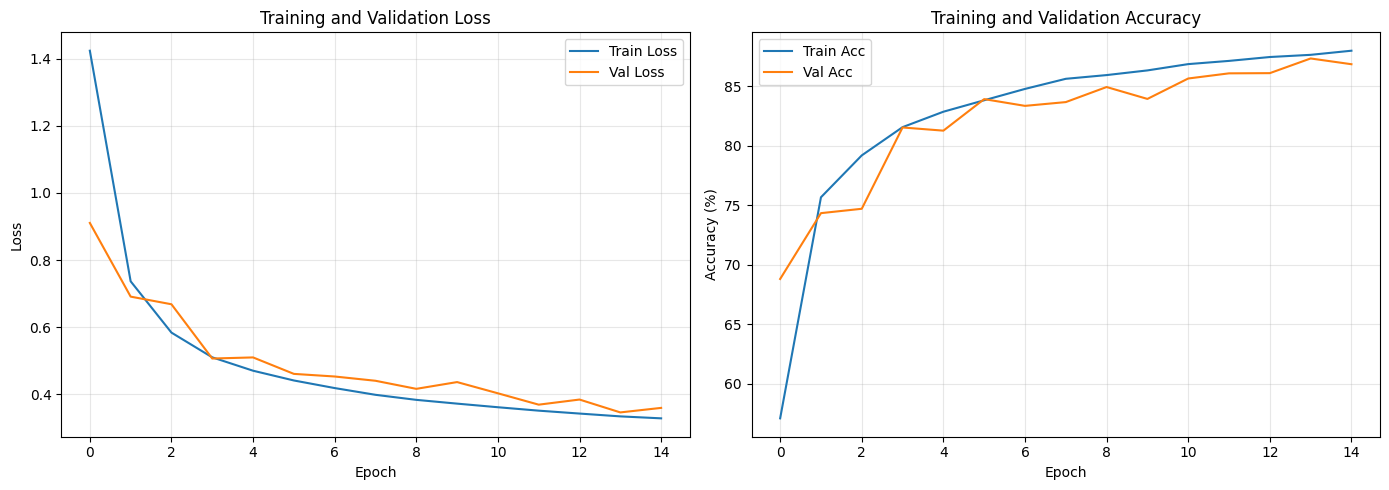

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history["train_loss"], label="Train Loss")
ax1.plot(history["val_loss"], label="Val Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history["train_acc"], label="Train Acc")
ax2.plot(history["val_acc"], label="Val Acc")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Training and Validation Accuracy")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 4: Evaluate DenseNet


In [7]:
model.load_state_dict(torch.load("best_densenet.pth"))
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"Test Accuracy: {test_acc:.2f}%")

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 88.14%


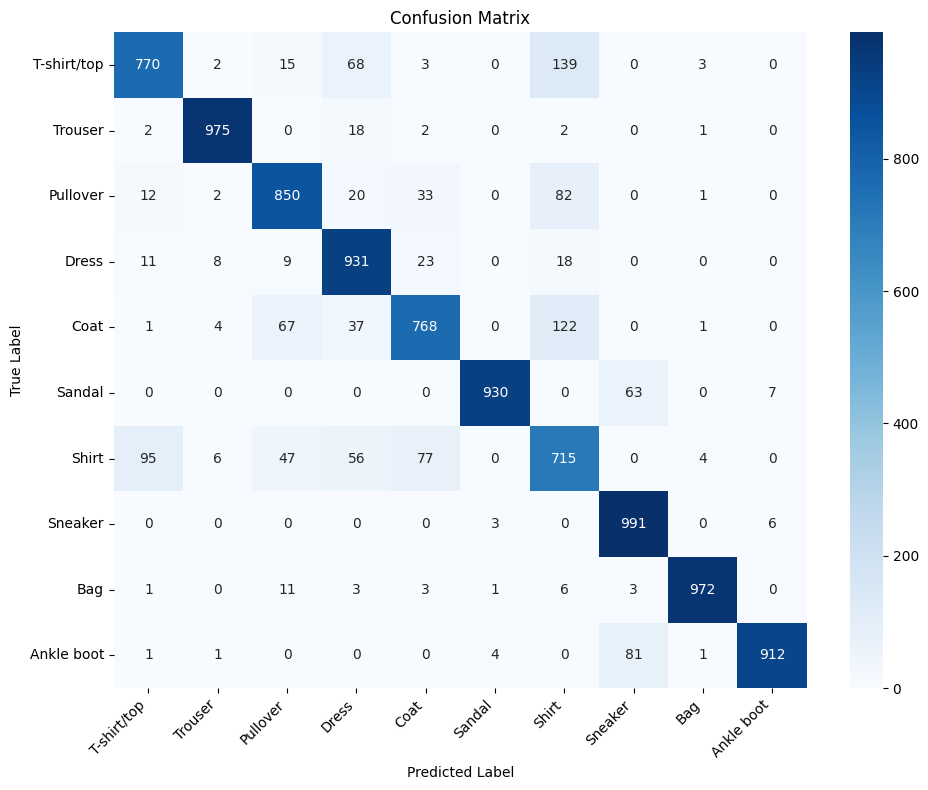


Classification Report:

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.77      0.81      1000
     Trouser       0.98      0.97      0.98      1000
    Pullover       0.85      0.85      0.85      1000
       Dress       0.82      0.93      0.87      1000
        Coat       0.84      0.77      0.80      1000
      Sandal       0.99      0.93      0.96      1000
       Shirt       0.66      0.71      0.69      1000
     Sneaker       0.87      0.99      0.93      1000
         Bag       0.99      0.97      0.98      1000
  Ankle boot       0.99      0.91      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



In [8]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

## Part 5: Siamese Network


In [9]:
class SiameseNetwork(nn.Module):
    def __init__(self, backbone, embedding_dim=128):
        super().__init__()
        self.backbone = backbone
        self.embedding = nn.Sequential(
            nn.Linear(backbone.num_features, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim),
        )

    def forward(self, x):
        features = self.backbone.get_features(x)
        embeddings = self.embedding(features)
        return F.normalize(embeddings, p=2, dim=1)


siamese_model = SiameseNetwork(model, embedding_dim=128).to(device)

for param in siamese_model.backbone.parameters():
    param.requires_grad = False

print(
    f"Trainable parameters: {sum(p.numel() for p in siamese_model.parameters() if p.requires_grad):,}"
)

Trainable parameters: 41,216


In [10]:
class TripletDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.labels = np.array([label for _, label in dataset])
        self.label_to_indices = {
            label: np.where(self.labels == label)[0] for label in np.unique(self.labels)
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        anchor_img, anchor_label = self.dataset[idx]

        positive_idx = idx
        while positive_idx == idx:
            positive_idx = np.random.choice(self.label_to_indices[anchor_label])
        positive_img, _ = self.dataset[positive_idx]

        negative_label = np.random.choice(
            [l for l in self.label_to_indices.keys() if l != anchor_label]
        )
        negative_idx = np.random.choice(self.label_to_indices[negative_label])
        negative_img, _ = self.dataset[negative_idx]

        return anchor_img, positive_img, negative_img


triplet_train = TripletDataset(train_dataset)
triplet_loader = DataLoader(triplet_train, batch_size=128, shuffle=True, num_workers=0)

print(f"Triplet dataset size: {len(triplet_train)}")

Triplet dataset size: 54000


In [11]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super().__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = F.pairwise_distance(anchor, positive, p=2)
        neg_dist = F.pairwise_distance(anchor, negative, p=2)
        loss = F.relu(pos_dist - neg_dist + self.margin)
        return loss.mean()


triplet_criterion = TripletLoss(margin=0.5)
triplet_optimizer = optim.Adam(siamese_model.embedding.parameters(), lr=0.001)
triplet_scheduler = optim.lr_scheduler.StepLR(triplet_optimizer, step_size=5, gamma=0.5)

In [12]:
num_triplet_epochs = 15
triplet_history = []

for epoch in range(num_triplet_epochs):
    siamese_model.train()
    total_loss = 0

    for anchor, positive, negative in tqdm(
        triplet_loader, desc=f"Epoch {epoch + 1}/{num_triplet_epochs}"
    ):
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        triplet_optimizer.zero_grad()

        anchor_emb = siamese_model(anchor)
        positive_emb = siamese_model(positive)
        negative_emb = siamese_model(negative)

        loss = triplet_criterion(anchor_emb, positive_emb, negative_emb)
        loss.backward()
        triplet_optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(triplet_loader)
    triplet_history.append(avg_loss)
    print(f"Epoch {epoch + 1}/{num_triplet_epochs} - Loss: {avg_loss:.4f}")

    triplet_scheduler.step()

torch.save(siamese_model.state_dict(), "siamese_model.pth")
print("\nSiamese model saved!")

Epoch 1/15:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 1/15 - Loss: 0.0491


Epoch 2/15:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 2/15 - Loss: 0.0457


Epoch 3/15:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 3/15 - Loss: 0.0455


Epoch 4/15:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 4/15 - Loss: 0.0444


Epoch 5/15:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 5/15 - Loss: 0.0437


Epoch 6/15:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 6/15 - Loss: 0.0435


Epoch 7/15:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 7/15 - Loss: 0.0435


Epoch 8/15:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 8/15 - Loss: 0.0431


Epoch 9/15:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 9/15 - Loss: 0.0421


Epoch 10/15:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 10/15 - Loss: 0.0425


Epoch 11/15:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 11/15 - Loss: 0.0428


Epoch 12/15:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 12/15 - Loss: 0.0428


Epoch 13/15:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 13/15 - Loss: 0.0426


Epoch 14/15:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 14/15 - Loss: 0.0418


Epoch 15/15:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 15/15 - Loss: 0.0419

Siamese model saved!


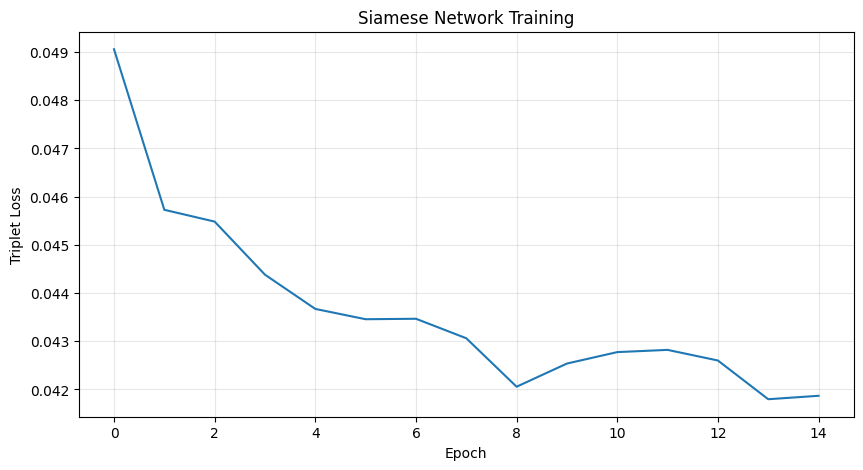

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(triplet_history)
plt.xlabel("Epoch")
plt.ylabel("Triplet Loss")
plt.title("Siamese Network Training")
plt.grid(True, alpha=0.3)
plt.show()

## Part 6: Generate Embeddings


In [14]:
siamese_model.load_state_dict(torch.load("siamese_model.pth"))
siamese_model.eval()

test_embeddings = []
test_labels = []
test_images = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Generating embeddings"):
        images = images.to(device)
        embeddings = siamese_model(images)
        test_embeddings.append(embeddings.cpu().numpy())
        test_labels.extend(labels.numpy())
        test_images.append(images.cpu())

test_embeddings = np.vstack(test_embeddings)
test_labels = np.array(test_labels)
test_images = torch.cat(test_images)

print(f"Embeddings shape: {test_embeddings.shape}")
print(f"Labels shape: {test_labels.shape}")

Generating embeddings:   0%|          | 0/79 [00:00<?, ?it/s]

Embeddings shape: (10000, 128)
Labels shape: (10000,)


## Part 7: Similar Image Search


Query: Coat | Distances: [0.01145475 0.01774825 0.02120035 0.02315172 0.02537438]


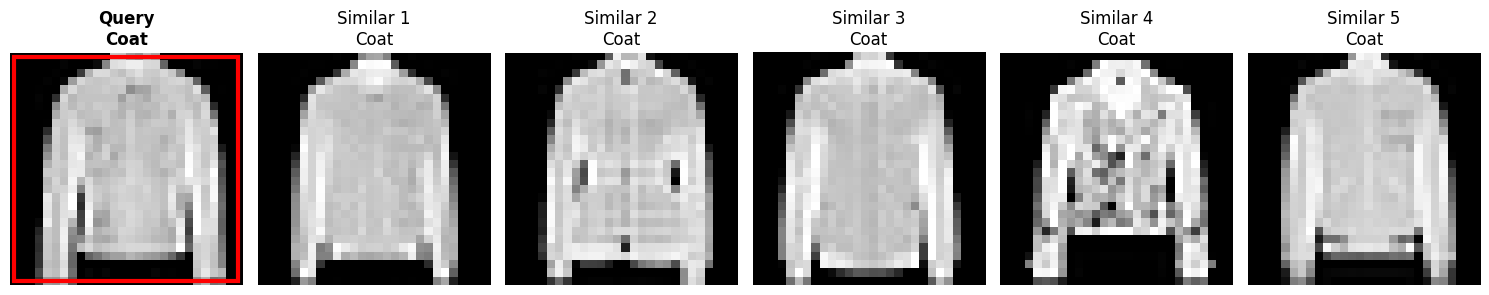

Query: Sneaker | Distances: [0.01603494 0.0204619  0.0235073  0.02351853 0.02535396]


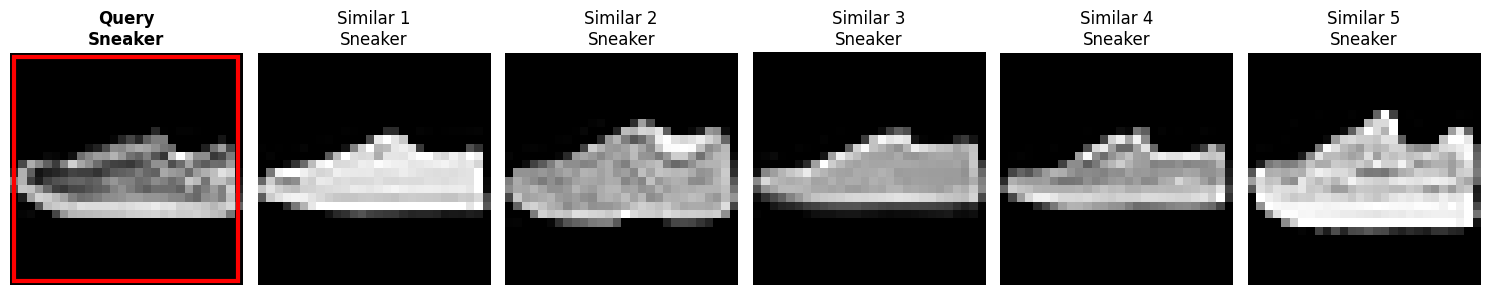

Query: Pullover | Distances: [0.04742875 0.0483702  0.05394476 0.05786155 0.06085948]


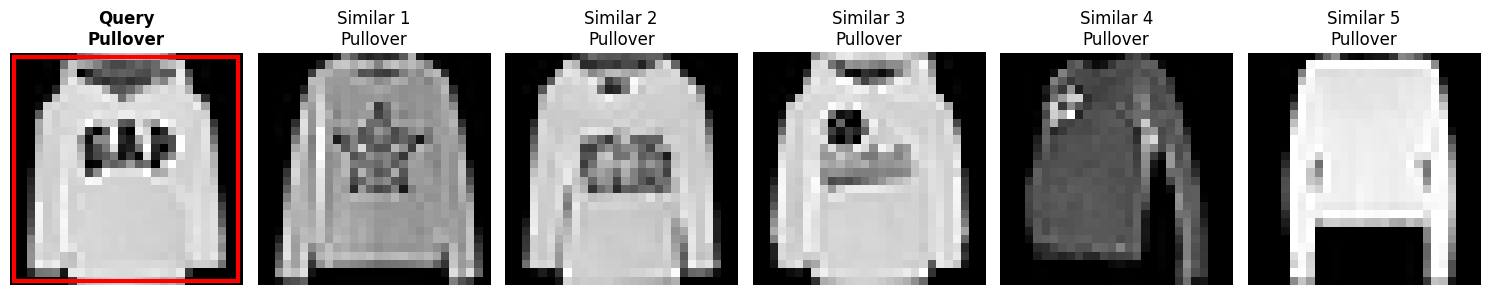

In [15]:
def find_similar_images(query_idx, embeddings, top_k=5):
    query_embedding = embeddings[query_idx]
    distances = np.linalg.norm(embeddings - query_embedding, axis=1)
    similar_indices = np.argsort(distances)[1 : top_k + 1]
    return similar_indices, distances[similar_indices]


def visualize_similar_images(query_idx, similar_indices, images, labels, class_names):
    fig, axes = plt.subplots(1, len(similar_indices) + 1, figsize=(15, 3))

    query_img = images[query_idx].squeeze().numpy()
    axes[0].imshow(query_img, cmap="gray")
    axes[0].set_title(f"Query\n{class_names[labels[query_idx]]}", fontweight="bold")
    axes[0].axis("off")
    axes[0].add_patch(
        plt.Rectangle(
            (0, 0),
            query_img.shape[1] - 1,
            query_img.shape[0] - 1,
            fill=False,
            edgecolor="red",
            linewidth=3,
        )
    )

    for i, idx in enumerate(similar_indices):
        img = images[idx].squeeze().numpy()
        axes[i + 1].imshow(img, cmap="gray")
        axes[i + 1].set_title(f"Similar {i + 1}\n{class_names[labels[idx]]}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()


for _ in range(3):
    query_idx = np.random.randint(0, len(test_embeddings))
    similar_indices, distances = find_similar_images(
        query_idx, test_embeddings, top_k=5
    )
    print(f"Query: {class_names[test_labels[query_idx]]} | Distances: {distances}")
    visualize_similar_images(
        query_idx, similar_indices, test_images, test_labels, class_names
    )

In [16]:
def evaluate_retrieval(embeddings, labels, k_values=[1, 3, 5, 10]):
    results = {k: [] for k in k_values}

    for i in tqdm(range(len(embeddings)), desc="Evaluating retrieval"):
        query_label = labels[i]
        distances = np.linalg.norm(embeddings - embeddings[i], axis=1)
        sorted_indices = np.argsort(distances)[1:]

        for k in k_values:
            top_k_labels = labels[sorted_indices[:k]]
            accuracy = np.mean(top_k_labels == query_label)
            results[k].append(accuracy)

    for k in k_values:
        avg_acc = np.mean(results[k]) * 100
        print(f"Top-{k} Accuracy: {avg_acc:.2f}%")


evaluate_retrieval(test_embeddings, test_labels)

Evaluating retrieval:   0%|          | 0/10000 [00:00<?, ?it/s]

Top-1 Accuracy: 85.60%
Top-3 Accuracy: 85.85%
Top-5 Accuracy: 85.51%
Top-10 Accuracy: 85.30%


## Part 8: t-SNE Visualization


In [17]:
sample_size = 5000
sample_indices = np.random.choice(len(test_embeddings), sample_size, replace=False)
sample_embeddings = test_embeddings[sample_indices]
sample_labels = test_labels[sample_indices]

print("Applying PCA for dimensionality reduction...")
pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(sample_embeddings)
print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")

print("Applying t-SNE...")
tsne = TSNE(
    n_components=2, perplexity=40, learning_rate=200, random_state=42
)
embeddings_tsne = tsne.fit_transform(embeddings_pca)

Applying PCA for dimensionality reduction...
PCA explained variance: 99.99%
Applying t-SNE...


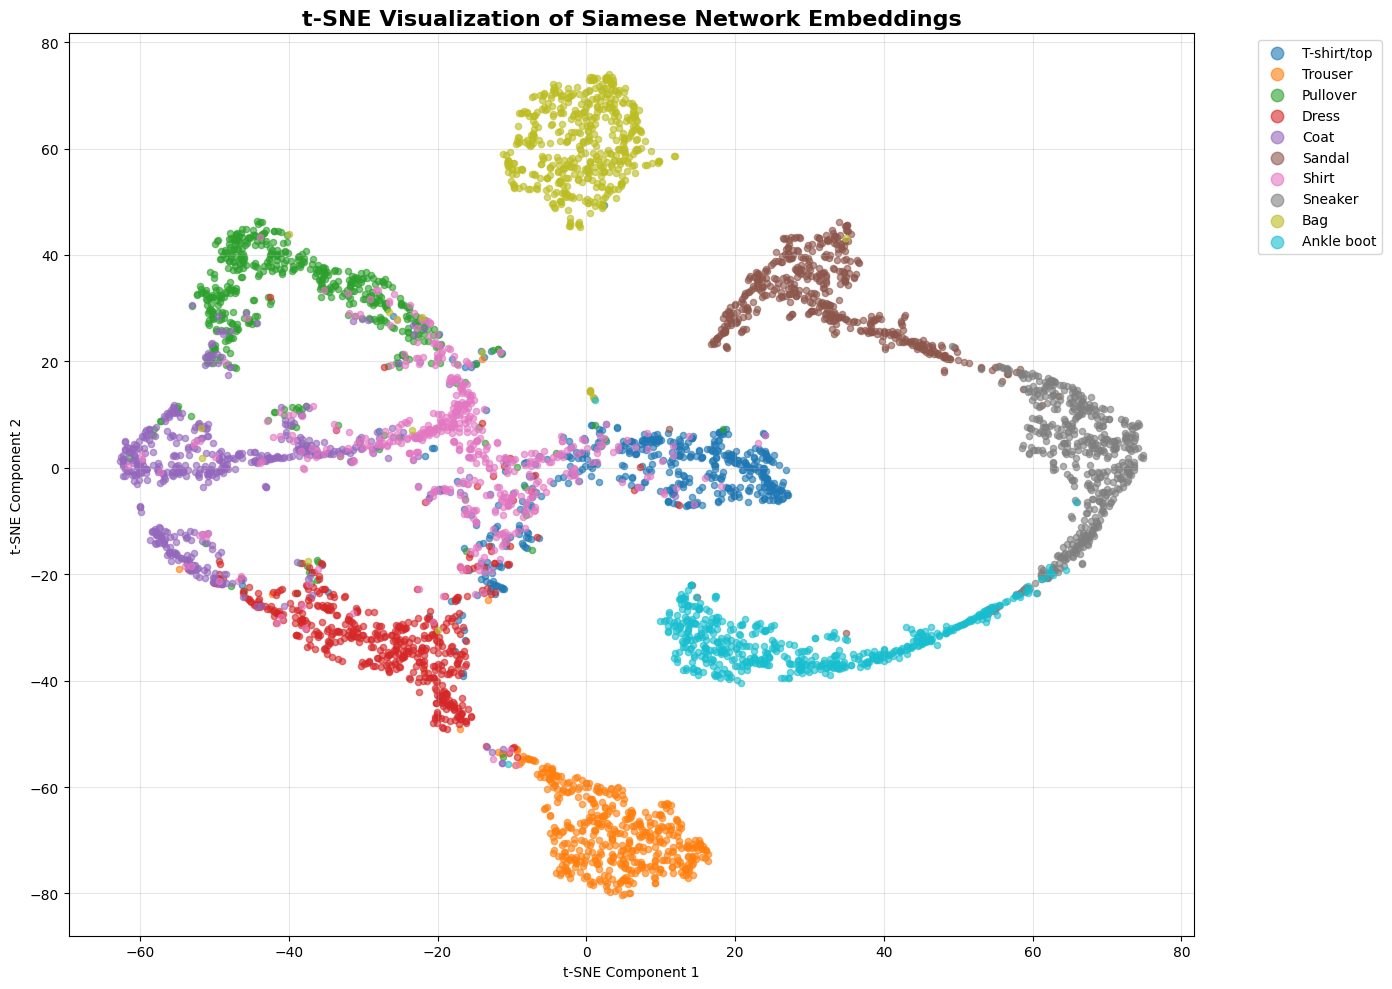

In [18]:
plt.figure(figsize=(14, 10))
colors = plt.cm.tab10(np.linspace(0, 1, 10))

for i, class_name in enumerate(class_names):
    mask = sample_labels == i
    plt.scatter(
        embeddings_tsne[mask, 0],
        embeddings_tsne[mask, 1],
        c=[colors[i]],
        label=class_name,
        alpha=0.6,
        s=20,
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", markerscale=2)
plt.title(
    "t-SNE Visualization of Siamese Network Embeddings", fontsize=16, fontweight="bold"
)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Part 9: Comparison with Raw Pixels and DenseNet Features


In [19]:
raw_images = test_images[sample_indices].view(sample_size, -1).numpy()

print("Extracting DenseNet features...")
model.eval()
densenet_features = []
with torch.no_grad():
    for idx in tqdm(sample_indices):
        img = test_images[idx : idx + 1].to(device)
        features = model.get_features(img)
        densenet_features.append(features.cpu().numpy())
densenet_features = np.vstack(densenet_features)

Extracting DenseNet features...


  0%|          | 0/5000 [00:00<?, ?it/s]

In [20]:
print("Applying t-SNE on raw pixels...")
pca_raw = PCA(n_components=50)
raw_pca = pca_raw.fit_transform(raw_images)
tsne_raw = TSNE(
    n_components=2, perplexity=40, learning_rate=200, random_state=42
)
raw_tsne = tsne_raw.fit_transform(raw_pca)

print("Applying t-SNE on DenseNet features...")
pca_dense = PCA(n_components=50)
dense_pca = pca_dense.fit_transform(densenet_features)
tsne_dense = TSNE(
    n_components=2, perplexity=40, learning_rate=200, random_state=42
)
dense_tsne = tsne_dense.fit_transform(dense_pca)

Applying t-SNE on raw pixels...
Applying t-SNE on DenseNet features...
Applying t-SNE on DenseNet features...


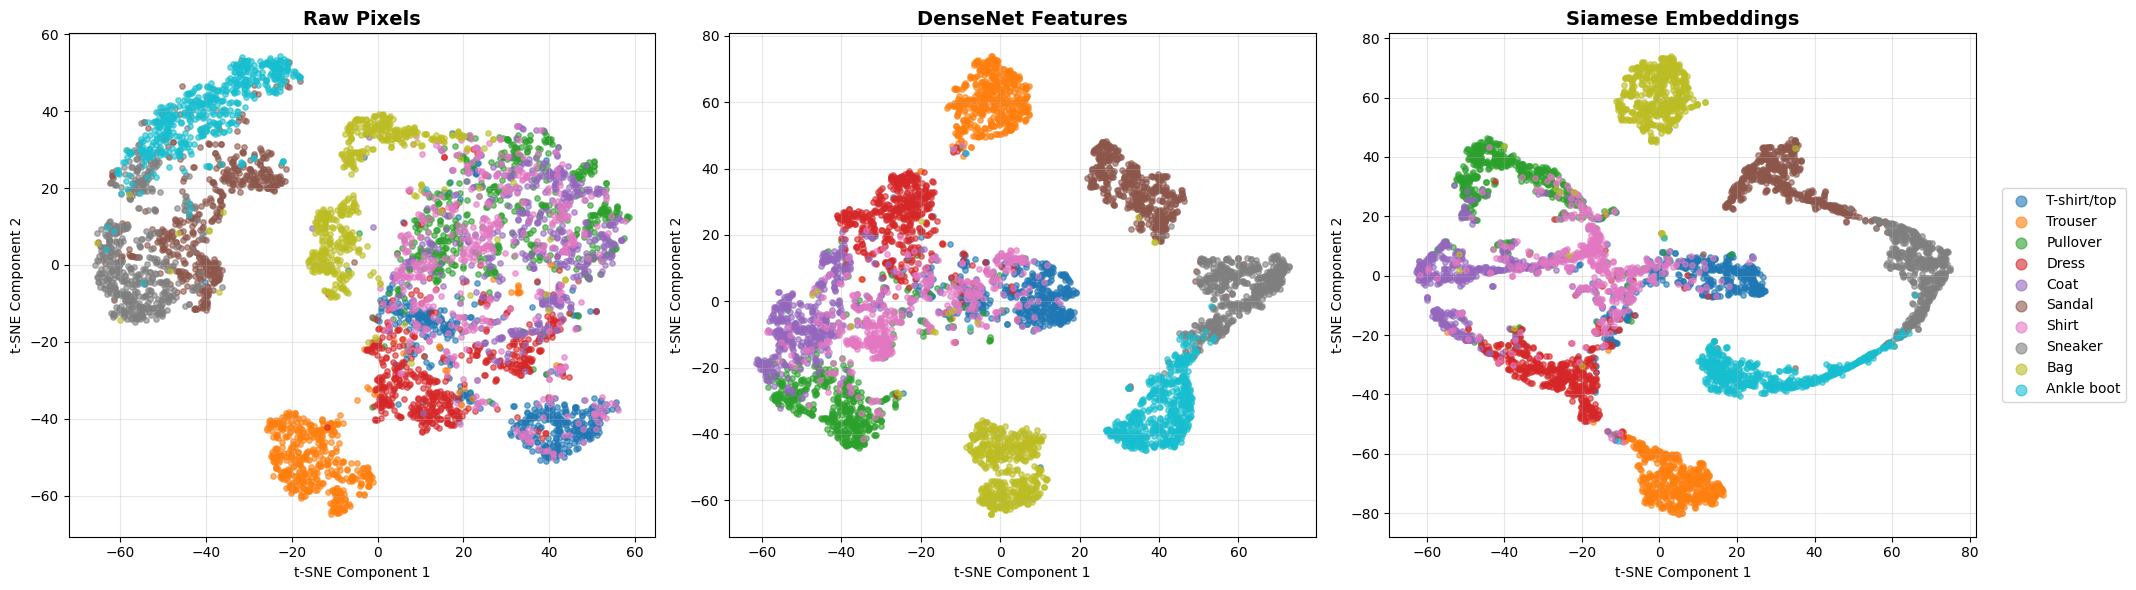

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
titles = ["Raw Pixels", "DenseNet Features", "Siamese Embeddings"]
data = [raw_tsne, dense_tsne, embeddings_tsne]

for ax, title, tsne_data in zip(axes, titles, data):
    for i, class_name in enumerate(class_names):
        mask = sample_labels == i
        ax.scatter(
            tsne_data[mask, 0],
            tsne_data[mask, 1],
            c=[colors[i]],
            label=class_name,
            alpha=0.6,
            s=15,
        )
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel("t-SNE Component 1")
    ax.set_ylabel("t-SNE Component 2")
    ax.grid(True, alpha=0.3)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1, 0.5), markerscale=2)
plt.tight_layout()
plt.show()

## Results Summary


In [22]:
print("LAB 3 RESULTS SUMMARY")
print("\n1. DenseNet Classification:")
print(f"   - Test Accuracy: {test_acc:.2f}%")
print(f"   - Model Parameters: {sum(p.numel() for p in model.parameters()):,}")
print("\n2. Siamese Network:")
print("   - Embedding Dimension: 128")
print(f"   - Final Triplet Loss: {triplet_history[-1]:.4f}")
print("\n3. Similar Image Search:")
print("   - Successfully implemented with Euclidean distance")
print("   - Top-k accuracy metrics computed")
print("\n4. t-SNE Visualization:")
print(f"   - Visualized {sample_size} samples")
print("   - Compared raw pixels, DenseNet features, and Siamese embeddings")
print("   - Clear class separation observed in Siamese embeddings")

LAB 3 RESULTS SUMMARY

1. DenseNet Classification:
   - Test Accuracy: 88.14%
   - Model Parameters: 303,274

2. Siamese Network:
   - Embedding Dimension: 128
   - Final Triplet Loss: 0.0419

3. Similar Image Search:
   - Successfully implemented with Euclidean distance
   - Top-k accuracy metrics computed

4. t-SNE Visualization:
   - Visualized 5000 samples
   - Compared raw pixels, DenseNet features, and Siamese embeddings
   - Clear class separation observed in Siamese embeddings
